In [1]:
# 🧠 02_predic_semana_distancia_total.ipynb
# Modelo de predicción semanal de Distancia Total
# Basado en la vista: vw_tipo_semana_modelo_extendida_v2

# 1️⃣ Importaciones
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import sqlite3

# 2️⃣ Carga de datos
# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"
conn = sqlite3.connect(db_path)

query = """
SELECT * FROM vw_tipo_semana_modelo_extendida_v3
"""

df = pd.read_sql(query, conn)
conn.close()
print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")



Datos cargados: 713 filas, 25 columnas


In [2]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

print(f"Registros cargados pre filtrado: {len(df)}\n")

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]


microciclos_excluir = [1, 2, 3, 4, 5, 6, 7]

# Filtrar jugadores no válidos
df = df[~df["microciclo_actual"].isin(microciclos_excluir)]

print(f"Registros cargados post filtrado: {len(df)}\n")
# Distribución de la etiqueta
print("\nDistribución de tipo_semana_next:")
print(df['tipo_semana_next'].value_counts(normalize=True) * 100)


Registros cargados pre filtrado: 713

Registros cargados post filtrado: 416


Distribución de tipo_semana_next:
tipo_semana_next
RECUPERO    41.794872
CARGA       36.153846
MANTENER    22.051282
Name: proportion, dtype: float64


In [3]:
# 3️⃣ LIMPIEZA Y SELECCIÓN DE VARIABLES
# Eliminamos columnas no necesarias o identificadores
drop_cols = [
    'id_jugador', 'nombre_jugador', 'Microciclo_Num', 
    'Fecha_Inicio', 'Fecha_Fin'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Eliminamos filas con nulos críticos
df = df.dropna(subset=['CT_total_actual', 'CE_total_actual', 'CS_total_actual', 'CR_total_actual','Distancia_total_total_next'])

print(f"✅ Filas tras limpieza: {len(df)}")

✅ Filas tras limpieza: 390


In [4]:
# 5️⃣ SELECCIÓN DE FEATURES (para modelo de Distancia_Total_Total)

FEATURES = [
    # 🔹 Cargas actuales
    'CT_total_actual', 'CE_total_actual', 'CS_total_actual', 'CR_total_actual',

    # 🔹 Estado fisiológico actual
    'riesgo_suavizado_3d_actual',

    # 🔹 Datos antropométricos del jugador
    'Edad', 'Peso_kg', 'Estatura_cm',

    # 🔹 Contexto estructural de la semana siguiente
    'entrenos_total_next', 'descansos_total_next', 'partidos_total_next',
    'descansos_pre_partido_next', 'entrenos_pre_partido_next', 'entrenos_post_partido_next',

    # 🔹 Tipo de semana prevista (RECUPERO / MANTENER / CARGA)
    'tipo_semana_next'
] + [c for c in df.columns if c.startswith('Pos_') or c.startswith('Lin_')]

# 🔸 Codificación one-hot para tipo_semana_next
X = pd.get_dummies(df[FEATURES], columns=['tipo_semana_next'], drop_first=False)

# 🎯 Target: Distancia_Total_Total de la próxima semana
y = df['Distancia_total_total_next']




📊 Métricas de rendimiento:
R²: 0.831
MAE: 2447.664
Correlación Spearman (ρ): 0.869
✅ R² (CV 5 folds): 0.869 ± 0.067
💾 Modelo y scaler guardados en: C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_CS_Microciclo


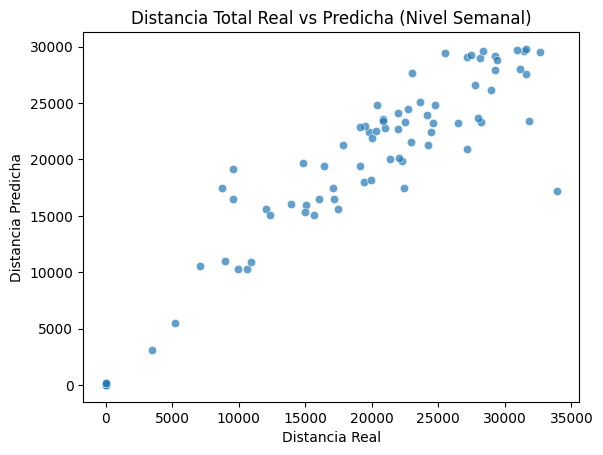

In [5]:
# 5️⃣ Split y Escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ Entrenamiento del Modelo
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

# 7️⃣ Evaluación
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rho, _ = spearmanr(y_test, y_pred)

print("📊 Métricas de rendimiento:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Correlación Spearman (ρ): {rho:.3f}")

# 8️⃣ Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"✅ R² (CV 5 folds): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 9️⃣ Exportar Modelo y Scaler
output_dir = r"C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\Prueba_ML2.0\Modelo_CS_Microciclo"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(model, os.path.join(output_dir, "model_semana_CS_rf.pkl"))
joblib.dump(scaler, os.path.join(output_dir, "scaler_semana_CS.pkl"))

print(f"💾 Modelo y scaler guardados en: {output_dir}")

# 🔟 Visualización de coherencia
import matplotlib.pyplot as plt
import seaborn as sns

df_eval = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred
})
sns.scatterplot(data=df_eval, x='Real', y='Predicho', alpha=0.7)
plt.title("Distancia Total Real vs Predicha (Nivel Semanal)")
plt.xlabel("Distancia Real")
plt.ylabel("Distancia Predicha")
plt.show()


### Conclisiones en el apartado prueba_ML2.0/CONCLUSIONES.ipynb